# Map Algebra in Python

Don't be scared – I'm not expecting you to write code. This is just to show that map algebra is really just very straightforward operations on 2D matrices. We'll use a series of very small layers with 4x6 pixels as examples.

But first, we'll load some python modules that we'll need:

In [2]:
import numpy as np        # good for dealing with matrices
import seaborn as sns     # good for nice plots 
from scipy import signal  # for the focal function
from skimage import graph # can do least cost

Let's define two layers, let's say one is ground elevation, the other one is the height of vegeation above ground:

In [3]:
elevation = np.array([ [ 1, 1, 3, 4, 4, 2],
                       [ 1, 3, 4, 4, 2, 1],
                       [ 1, 2, 2, 3, 2, 0],
                       [ 1, 1, 2, 4, 0, 0]])

building = np.array([ [0, 1, 1, 1, 1, 2],
                       [ 1, 1, 1, 1, 1, 1],
                       [ 0, 1, 2, 3, 4, 0],
                       [ 0, 1, 0, 1, 0, 0]])

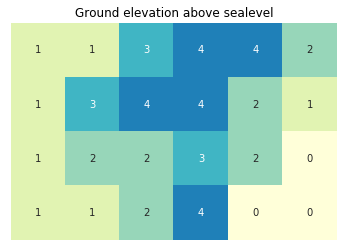

In [8]:
fig = sns.heatmap(elevation, annot=True, square=True, xticklabels=False, yticklabels=False, cmap="YlGnBu", cbar=False, vmin=0, vmax=6).set_title('Ground elevation above sealevel')
fig.figure.savefig("elevation.pdf")

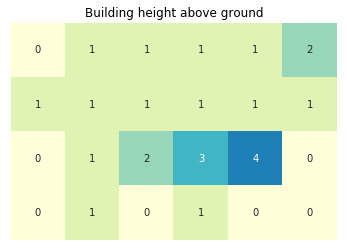

In [10]:
fig = sns.heatmap(building, annot=True, square=True, xticklabels=False, yticklabels=False, cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Building height above ground')
fig.figure.savefig("building.pdf")

## 1. Local operation: Calculate building height above sea level

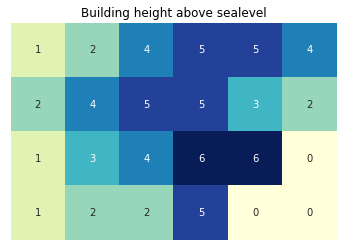

In [12]:
building_above_sealevel = elevation + building

fig = sns.heatmap(building_above_sealevel, annot=True, square=True, xticklabels=False, yticklabels=False, cbar=False, cmap="YlGnBu").set_title('Building height above sealevel')
fig.figure.savefig("elevation+building.pdf")

## 2. Focal operation: Fix errors in elevation raster

Let's assume our elevation raster has a measurement error, e.g. because a bird flew under the LiDAR, so one pixel has  a too high value:

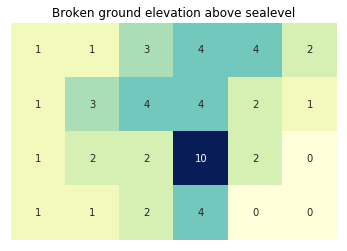

In [13]:
broken_elevation = elevation
broken_elevation[2,3] = 10

fig = sns.heatmap(broken_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, cbar=False, cmap="YlGnBu").set_title('Broken ground elevation above sealevel')
fig.figure.savefig("broken.pdf")

We'll fix this by running a 3x3 window over it that sets every pixel to the average of it's 8 neighbors:

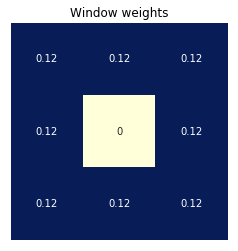

In [14]:
window = np.array([ [ 1/8., 1/8., 1/8.,],
                    [ 1/8., 0, 1/8.,],
                    [ 1/8., 1/8., 1/8.,],])

fig = sns.heatmap(window, annot=True, square=True, xticklabels=False, yticklabels=False, cbar=False, cmap="YlGnBu").set_title('Window weights')
fig.figure.savefig("window.pdf")

/Users/carsten/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/carsten/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


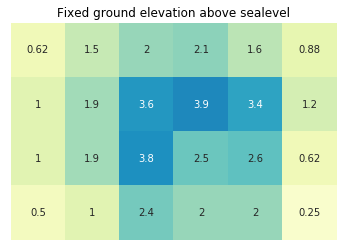

In [15]:
fixed_elevation = signal.convolve(broken_elevation, window, mode="same") # "moving window" function

fig = sns.heatmap(fixed_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Fixed ground elevation above sealevel')
fig.figure.savefig("fixed.pdf")

Note that functions like this one always affect **all cells** (not just the "broken" one) and have **edge effects**!

## 3. Zonal operation: Average vegetation height per zone

Let's define two zones and calculate the average vegetation height per zone:

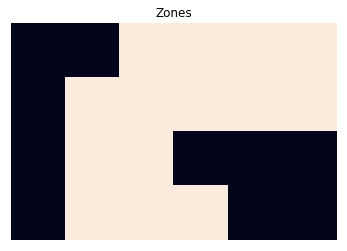

In [16]:
zones = np.array([ [0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 0],
                   [0, 1, 1, 1, 0, 0]])

fig = sns.heatmap(zones, square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Zones')
fig.figure.savefig("zonal1.pdf")

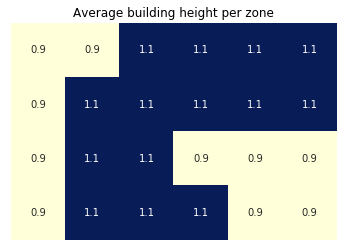

In [21]:
avg_veg_height = np.copy(zones).astype(float)

for zone in np.unique(zones):
    avg_veg_height[zones == zone] = np.mean(building[zones == zone])
    
fig = sns.heatmap(avg_veg_height, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Average building height per zone')
fig.figure.savefig("zonal2.pdf")

## 4. Global operation: Cost distance

We'll use or elevation layer as a cost surface and calculate the cost to travel to each cell from a given start cell.

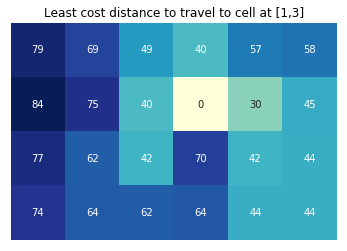

In [22]:
# turn our elevation into a cost surface
cellSize = 10
lg = graph.MCP_Geometric(elevation, sampling=(cellSize, cellSize))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=[(1, 3)])[0]
fig = sns.heatmap(lcd, annot=True, square=True, xticklabels=False, yticklabels=False, cbar=False, cmap="YlGnBu").set_title('Least cost distance to travel to cell at [1,3]')
fig.figure.savefig("global.pdf")

Calculate an example path, here from the top left pixel to our source, using [route_through_array](http://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#route-through-array)

In [26]:
from skimage.graph import route_through_array

In [27]:
route_through_array(elevation, [0, 1], [1, 3])

([(0, 1), (0, 2), (1, 3)], 6.949747468305833)